In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.preprocessing import LabelEncoder
import nltk
from sklearn.model_selection import train_test_split
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import time

import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
df_data = pd.read_csv('gdrive/My Drive/TA/shuffle.csv')
df_data.head()

,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,...,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Type
0,60457,192.168.100.190-192.168.100.191-1883-18273-17,192.168.100.191,18273,192.168.100.190,1883,17,30/01/2022 08:14:53 PM,62708806,38,1,2432.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.980302e+01,0.621922,1.650232e+06,24543.689747,1729462.0,1615776.0,61086321.0,1.650982e+06,24436.903517,1729462.0,1615776.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.641026,64.0,64.0,0,0,0,0,0,0,38,2432,1,64,-1,-1,38,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
1,37544,192.168.100.189-192.168.100.190-64446-1883-6,192.168.100.189,64446,192.168.100.190,1883,6,18/01/2022 10:37:29 AM,14,0,2,0.0,45.0,0.0,0.0,0.0,0.0,45.0,0.0,22.5,31.819805,3.214286e+06,142857.142857,1.400000e+01,0.000000,14.0,14.0,0.0,0.000000e+00,0.000000,0.0,0.0,14.0,14.0,0.0,14.0,14.0,0,1,0,...,0.0,45.0,30.0,25.980762,675.0,0,0,0,1,1,0,0,0,0.0,45.000000,0.0,22.5,0,0,0,0,0,0,0,0,2,45,-1,64067,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,51508,192.168.100.190-192.168.100.195-1883-54410-6,192.168.100.190,1883,192.168.100.195,54410,6,18/01/2022 02:12:12 PM,502,0,2,0.0,45.0,0.0,0.0,0.0,0.0,45.0,0.0,22.5,31.819805,8.964143e+04,3984.063745,5.020000e+02,0.000000,502.0,502.0,0.0,0.000000e+00,0.000000,0.0,0.0,502.0,502.0,0.0,502.0,502.0,0,1,0,...,0.0,45.0,30.0,25.980762,675.0,0,0,0,1,1,0,0,0,0.0,45.000000,0.0,22.5,0,0,0,0,0,0,0,0,2,45,-1,502,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,99267,192.168.100.190-192.168.100.191-1883-44688-17,192.168.100.191,44688,192.168.100.190,1883,17,30/01/2022 08:14:53 PM,62725033,38,1,2432.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.979273e+01,0.621761,1.650659e+06,22538.453251,1704292.0,1602252.0,61037195.0,1.649654e+06,21969.470217,1704292.0,1602252.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.641026,64.0,64.0,0,0,0,0,0,0,38,2432,1,64,-1,-1,38,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS
4,54484,192.168.100.190-192.168.100.191-1883-16890-17,192.168.100.191,16890,192.168.100.190,1883,17,30/01/2022 08:14:53 PM,64376045,39,1,2496.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.976634e+01,0.621349,1.650668e+06,24189.592423,1729929.0,1616428.0,62752981.0,1.651394e+06,24079.350651,1729929.0,1616428.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.600000,64.0,64.0,0,0,0,0,0,0,39,2496,1,64,-1,-1,39,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS


In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118839 entries, 0 to 118838
Data columns (total 85 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         118839 non-null  int64  
 1   Flow ID            118839 non-null  object 
 2   Src IP             118839 non-null  object 
 3   Src Port           118839 non-null  int64  
 4   Dst IP             118839 non-null  object 
 5   Dst Port           118839 non-null  int64  
 6   Protocol           118839 non-null  int64  
 7   Timestamp          118839 non-null  object 
 8   Flow Duration      118839 non-null  int64  
 9   Tot Fwd Pkts       118839 non-null  int64  
 10  Tot Bwd Pkts       118839 non-null  int64  
 11  TotLen Fwd Pkts    118839 non-null  float64
 12  TotLen Bwd Pkts    118839 non-null  float64
 13  Fwd Pkt Len Max    118839 non-null  float64
 14  Fwd Pkt Len Min    118839 non-null  float64
 15  Fwd Pkt Len Mean   118839 non-null  float64
 16  Fw

In [4]:
df_data['Src IP'] = df_data['Src IP'].apply(pd.to_numeric, errors='coerce')
df_data['Dst IP'] = df_data['Dst IP'].apply(pd.to_numeric, errors='coerce')
df_data['Flow ID'] = df_data['Flow ID'].apply(pd.to_numeric, errors='coerce')
df_data['Timestamp'] = df_data['Timestamp'].apply(pd.to_numeric, errors='coerce')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118839 entries, 0 to 118838
Data columns (total 85 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         118839 non-null  int64  
 1   Flow ID            0 non-null       float64
 2   Src IP             0 non-null       float64
 3   Src Port           118839 non-null  int64  
 4   Dst IP             0 non-null       float64
 5   Dst Port           118839 non-null  int64  
 6   Protocol           118839 non-null  int64  
 7   Timestamp          0 non-null       float64
 8   Flow Duration      118839 non-null  int64  
 9   Tot Fwd Pkts       118839 non-null  int64  
 10  Tot Bwd Pkts       118839 non-null  int64  
 11  TotLen Fwd Pkts    118839 non-null  float64
 12  TotLen Bwd Pkts    118839 non-null  float64
 13  Fwd Pkt Len Max    118839 non-null  float64
 14  Fwd Pkt Len Min    118839 non-null  float64
 15  Fwd Pkt Len Mean   118839 non-null  float64
 16  Fw

In [5]:
print(df_data.isna().sum())

Unnamed: 0         0
Flow ID       118839
Src IP        118839
Src Port           0
Dst IP        118839
               ...  
Idle Mean          0
Idle Std           0
Idle Max           0
Idle Min           0
Type               0
Length: 85, dtype: int64


In [6]:
df_data.drop(['Src IP', 'Dst IP', 'Flow ID','Timestamp','Unnamed: 0'], axis=1, inplace = True)
print(df_data.isna().sum())

Src Port         0
Dst Port         0
Protocol         0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Type             0
Length: 80, dtype: int64


In [7]:
le = LabelEncoder()
 
df_data['Type']= le.fit_transform(df_data['Type'])

print(df_data['Type'])

0         0
1         1
2         1
3         0
4         0
         ..
118834    0
118835    0
118836    0
118837    0
118838    1
Name: Type, Length: 118839, dtype: int64


In [8]:
df_data

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Type
0,18273,1883,17,62708806,38,1,2432.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.980302e+01,0.621922,1.650232e+06,24543.689747,1729462.0,1615776.0,61086321.0,1.650982e+06,24436.903517,1729462.0,1615776.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,304,8,0.605975,0.015947,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.641026,64.0,64.0,0,0,0,0,0,0,38,2432,1,64,-1,-1,38,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,64446,1883,6,14,0,2,0.0,45.0,0.0,0.0,0.0,0.0,45.0,0.0,22.5,31.819805,3.214286e+06,142857.142857,1.400000e+01,0.000000,14.0,14.0,0.0,0.000000e+00,0.000000,0.0,0.0,14.0,14.0,0.0,14.0,14.0,0,1,0,0,0,40,0.000000,142857.142857,0.0,45.0,30.0,25.980762,675.0,0,0,0,1,1,0,0,0,0.0,45.000000,0.0,22.5,0,0,0,0,0,0,0,0,2,45,-1,64067,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1883,54410,6,502,0,2,0.0,45.0,0.0,0.0,0.0,0.0,45.0,0.0,22.5,31.819805,8.964143e+04,3984.063745,5.020000e+02,0.000000,502.0,502.0,0.0,0.000000e+00,0.000000,0.0,0.0,502.0,502.0,0.0,502.0,502.0,0,1,0,0,0,64,0.000000,3984.063745,0.0,45.0,30.0,25.980762,675.0,0,0,0,1,1,0,0,0,0.0,45.000000,0.0,22.5,0,0,0,0,0,0,0,0,2,45,-1,502,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,44688,1883,17,62725033,38,1,2432.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.979273e+01,0.621761,1.650659e+06,22538.453251,1704292.0,1602252.0,61037195.0,1.649654e+06,21969.470217,1704292.0,1602252.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,304,8,0.605819,0.015943,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.641026,64.0,64.0,0,0,0,0,0,0,38,2432,1,64,-1,-1,38,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,16890,1883,17,64376045,39,1,2496.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.976634e+01,0.621349,1.650668e+06,24189.592423,1729929.0,1616428.0,62752981.0,1.651394e+06,24079.350651,1729929.0,1616428.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,312,8,0.605815,0.015534,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.600000,64.0,64.0,0,0,0,0,0,0,39,2496,1,64,-1,-1,39,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118834,4812,1883,17,64382620,39,1,2496.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.976228e+01,0.621286,1.650836e+06,23744.325717,1722404.0,1605749.0,62750015.0,1.651316e+06,23870.711936,1722404.0,1605749.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,312,8,0.605754,0.015532,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.600000,64.0,64.0,0,0,0,0,0,0,39,2496,1,64,-1,-1,39,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
118835,36386,1883,17,62719853,38,1,2432.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.979601e+01,0.621813,1.650522e+06,23940.611602,1713565.0,1608599.0,61049086.0,1.649975e+06,24028.766316,1713565.0,1608599.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,304,8,0.605869,0.0159

In [9]:
x = df_data.drop(['Type'], axis = 1)
x.head()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,18273,1883,17,62708806,38,1,2432.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.980302e+01,0.621922,1.650232e+06,24543.689747,1729462.0,1615776.0,61086321.0,1.650982e+06,24436.903517,1729462.0,1615776.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,304,8,0.605975,0.015947,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.641026,64.0,64.0,0,0,0,0,0,0,38,2432,1,64,-1,-1,38,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64446,1883,6,14,0,2,0.0,45.0,0.0,0.0,0.0,0.0,45.0,0.0,22.5,31.819805,3.214286e+06,142857.142857,1.400000e+01,0.000000,14.0,14.0,0.0,0.000000e+00,0.000000,0.0,0.0,14.0,14.0,0.0,14.0,14.0,0,1,0,0,0,40,0.000000,142857.142857,0.0,45.0,30.0,25.980762,675.0,0,0,0,1,1,0,0,0,0.0,45.000000,0.0,22.5,0,0,0,0,0,0,0,0,2,45,-1,64067,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1883,54410,6,502,0,2,0.0,45.0,0.0,0.0,0.0,0.0,45.0,0.0,22.5,31.819805,8.964143e+04,3984.063745,5.020000e+02,0.000000,502.0,502.0,0.0,0.000000e+00,0.000000,0.0,0.0,502.0,502.0,0.0,502.0,502.0,0,1,0,0,0,64,0.000000,3984.063745,0.0,45.0,30.0,25.980762,675.0,0,0,0,1,1,0,0,0,0.0,45.000000,0.0,22.5,0,0,0,0,0,0,0,0,2,45,-1,502,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44688,1883,17,62725033,38,1,2432.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.979273e+01,0.621761,1.650659e+06,22538.453251,1704292.0,1602252.0,61037195.0,1.649654e+06,21969.470217,1704292.0,1602252.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,304,8,0.605819,0.015943,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.641026,64.0,64.0,0,0,0,0,0,0,38,2432,1,64,-1,-1,38,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16890,1883,17,64376045,39,1,2496.0,64.0,64.0,64.0,64.0,0.0,64.0,64.0,64.0,0.000000,3.976634e+01,0.621349,1.650668e+06,24189.592423,1729929.0,1616428.0,62752981.0,1.651394e+06,24079.350651,1729929.0,1616428.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,312,8,0.605815,0.015534,64.0,64.0,64.0,0.000000,0.0,0,0,0,0,0,0,0,0,0.0,65.600000,64.0,64.0,0,0,0,0,0,0,39,2496,1,64,-1,-1,39,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
sc_X = StandardScaler()
x = sc_X.fit_transform(x)

In [11]:
y = df_data['Type']
y.head()

0    0
1    1
2    1
3    0
4    0
Name: Type, dtype: int64

In [12]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({0: 65576, 1: 53263})


In [13]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
x, y = oversample.fit_resample(x, y)

In [14]:
from collections import Counter
counter = Counter(y)
print(counter)

Counter({0: 65576, 1: 65576})


In [15]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state= 100)

In [16]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [17]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]) ,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=72, verbose=1, validation_data=(X_test, y_test), shuffle=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               106496    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 106,625
Trainable params: 106,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1458/1458 [==============================] - 21s 9ms/step - loss: 0.0113 - accuracy: 0.9991 - val_loss: 0.0051 - val_accuracy: 0.9994
Epoch 2/50
1458/1458 [===============

In [18]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print(y_pred)

[[False]
 [False]
 [False]
 ...
 [ True]
 [False]
 [ True]]


In [19]:
y_pred = y_pred[:, 0]
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

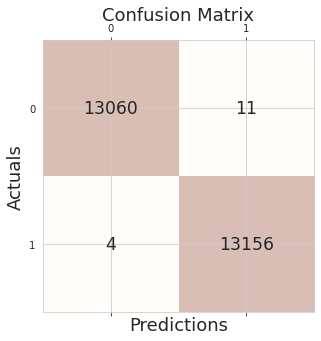

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [21]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

Accuracy: 0.999428
Precision: 0.999165
Recall: 0.999696
